In [1]:
pip install pandas matplotlib prophet scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [4]:
df = pd.read_csv("Sample - Superstore.csv", encoding='latin1')
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [12]:
# Convert Order Date to datetime
df['Order Date'] = pd.to_datetime(df['Order Date'])

# Keep only required columns
df = df[['Order Date', 'Sales']]

# Remove missing values
df.dropna(inplace=True)

# Aggregate sales to monthly level
monthly_sales = (
    df.groupby(pd.Grouper(key='Order Date', freq='ME'))
      .sum()
      .reset_index()
)

print(monthly_sales.head())

  Order Date      Sales
0 2014-01-31  14236.895
1 2014-02-28   4519.892
2 2014-03-31  55691.009
3 2014-04-30  28295.345
4 2014-05-31  23648.287


In [13]:
prophet_df = monthly_sales.rename(columns={
    'Order Date': 'ds',
    'Sales': 'y'
})

In [16]:
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='additive'
)

model.fit(prophet_df)

future = model.make_future_dataframe(periods=12, freq='ME')
forecast = model.predict(future)

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

14:15:33 - cmdstanpy - INFO - Chain [1] start processing
14:15:33 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
55,2018-08-31,61936.115362,53199.955929,71634.532151
56,2018-09-30,98895.785086,89840.466564,107957.201830
57,2018-10-31,67553.702926,58229.852888,76836.171559
58,2018-11-30,109972.726998,100832.589700,118929.594407
59,2018-12-31,101864.690255,92698.819217,111356.552444


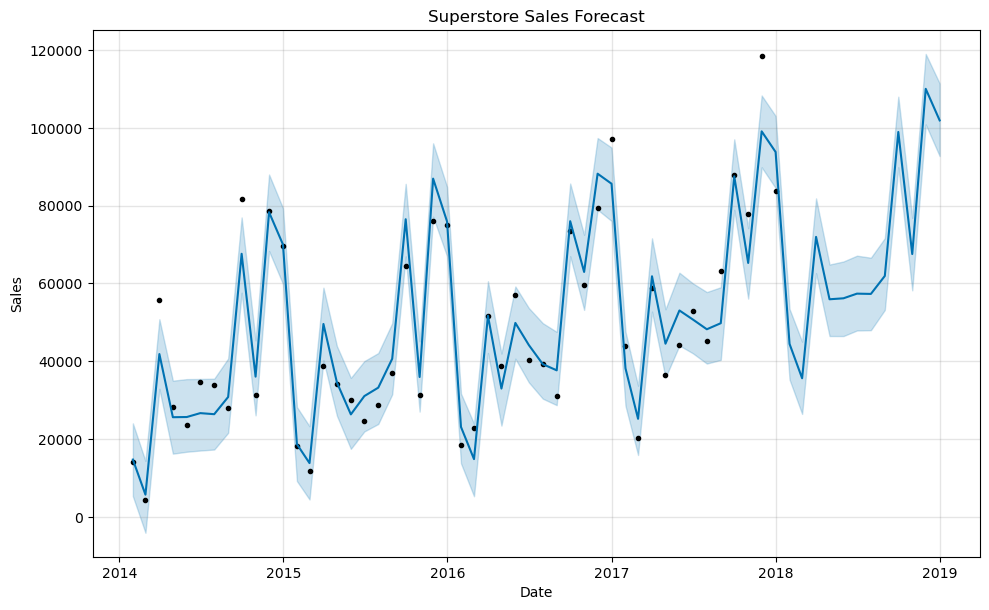

In [17]:
model.plot(forecast)
plt.title("Superstore Sales Forecast")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

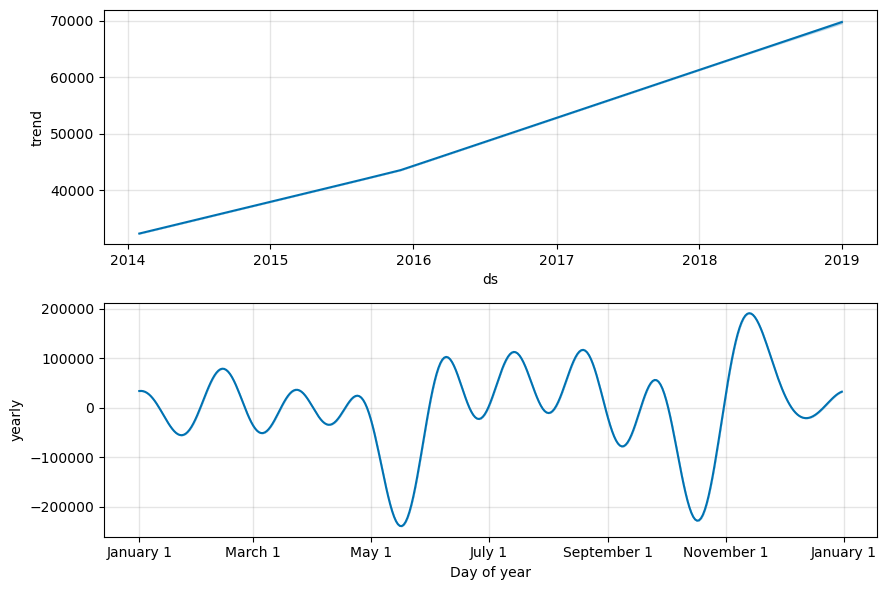

In [18]:
# Trend and Seasonality
model.plot_components(forecast)
plt.show()

In [20]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Align predictions with actual values
actual = prophet_df['y']
predicted = forecast.iloc[:len(actual)]['yhat']

# Calculate MAE
mae = mean_absolute_error(actual, predicted)

# Calculate RMSE manually
mse = mean_squared_error(actual, predicted)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Mean Absolute Error (MAE): 5665.15
Root Mean Squared Error (RMSE): 7260.16


In [21]:
forecast_output = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

forecast_output.to_csv("sales_forecast.csv", index=False)

print("Forecast saved as sales_forecast.csv")

Forecast saved as sales_forecast.csv
